# About
This was used to produce Table 1 and Figure 2.

# Prereqs

In [1]:
import collections
import configparser
import csv
import gzip
import pathlib
import time
import xml.etree.ElementTree

In [69]:
import numpy
import pandas
import seaborn
from IPython.display import HTML
from matplotlib import pyplot

In [70]:
from html_table import Table, Rows, Row, Cell

In [2]:
%matplotlib inline

In [3]:
MAIN_DIR = pathlib.Path('/nfs/brubeck.bx.psu.edu/scratch5/nick/overlaps/auto/ecoli')
CSV_PATH = MAIN_DIR/'sra.runinfo3.csv.gz'
XML_PATH = MAIN_DIR/'sra.docsum2.xml.gz'

## Reading metadata

In [4]:
def read_runinfo(csv_path):
  start = time.perf_counter()
  int_fields = {'spots', 'spots_with_mates', 'avgLength', 'size_MB', 'InsertSize', 'InsertDev', 'ProjectID', 'TaxID'}
  runs = {}
  header = {}
  empty_lines = 0
  header_lines = 0
  try:
    with gzip.open(csv_path, 'rt') as csv_file:
      for row in csv.reader(csv_file):
        if not header:
          header_lines += 1
          for i, value in enumerate(row):
            header[i] = value
          RunInfo = collections.namedtuple('RunInfo', header.values())
          continue
        if len(row) == 0:
          empty_lines += 1
          continue
        assert len(row) == len(header), (len(row), row)
        header_matches = 0
        value_dict = {}
        for i, raw_value in enumerate(row):
          if raw_value == header[i]:
            header_matches += 1
          else:
            if header[i] in int_fields:
              try:
                value = int(raw_value)
              except ValueError:
                if header[i] == 'InsertDev':
                  value = float(raw_value)
                else:
                  print(f'{header[i]}: {raw_value!r}', file=sys.stderr)
            else:
              value = raw_value
          value_dict[header[i]] = value
        if header_matches > 5:
          header_lines += 1
          continue
        runs[value_dict['Run']] = RunInfo(**value_dict)
  except EOFError:
    print('Incomplete gzip.', file=sys.stderr)
  elapsed = time.perf_counter() - start
  print(f'{len(runs)} runs in {elapsed:0.1f} seconds (headers: {header_lines}, empty lines: {empty_lines})')
  return runs

In [5]:
def read_xml(xml_path):
  start = time.perf_counter()
  summaries = {}
  with gzip.open(xml_path) as xml_file:
    # Note: This takes about 1-2GB of memory.
    tree = xml.etree.ElementTree.parse(xml_file)
  docsum = tree.getroot()
  for exp in docsum:
    for run in exp.find('./Runs'):
      acc = run.attrib['acc']
      summaries[acc] = exp
  elapsed = time.perf_counter() - start
  print(f'{len(summaries)} experiments in {round(elapsed)} seconds')
  return summaries

In [6]:
def get_xml_experiment(accession, summaries):
  try:
    return summaries[accession]
  except KeyError:
    sys.stderr.write(f'Warning: Could not find XML summary for {accession}\n')
    return None

In [7]:
def truncate(string, max_len):
  if len(string) > max_len:
    return string[:max_len-1]+'…'
  else:
    return string

In [8]:
def rm_prefix(string, prefix):
  if string.startswith(prefix):
    return string[len(prefix):]
  else:
    return string

## Read in the metadata

In [9]:
RUNS = read_runinfo(CSV_PATH)

186022 runs in 11.9 seconds (headers: 1, empty lines: 0)


In [10]:
SUMMARIES = read_xml(XML_PATH)

186022 experiments in 34 seconds


## Study objects

In [11]:
ABBREVIATIONS = {
  'European':'Euro.', 'Nucleotide':'Nuc.', 'Institute':'Inst.', 'Technology':'Tech.', 'The Pennsylvania':'Penn',
  'University':'Univ.', 'National':'Nat.', 'Department':'Dept.', 'Technological':'Tech.', 'Laboratory':'Lab.',
  'Biotechnology':'Biotech.',
}
class Study(collections.namedtuple('Study', ('title', 'study', 'center', 'lab', 'contact'))):
  __slots__ = ()
  @property
  def submitter(self):
    return (self.center, self.lab, self.contact)
  @classmethod
  def from_accession(cls, accession, summaries=SUMMARIES):
    try:
      experiment = summaries[accession]
    except KeyError:
      sys.stderr.write(f'Warning: Could not find XML summary for {accession}\n')
      raise
    return cls.from_experiment(experiment)
  @classmethod
  def from_experiment(cls, experiment):
    data = {'title':None, 'study':None, 'center':None, 'lab':None, 'contact':None}
    if not experiment:
      return cls(**data)
    data['title'] = experiment.find('./ExpXml/Summary/Title').text
    study_elem = experiment.find('./ExpXml/Study')
    data['study'] = study_elem.attrib.get('name')
    subm_elem = experiment.find('./ExpXml/Submitter')
    for field in 'center', 'lab', 'contact':
      data[field] = subm_elem.attrib.get(field+'_name')
    return cls(**data)
  def format_fields(self, max_len=None, null='?'):
    """Return a copy with the fields formatted for human reading."""
    strs = {}
    for field in self._fields:
      value = raw_value = getattr(self, field)
      if raw_value is None:
        value = null
      strs[field] = value
    # This is a common prefix that's lengthy and not too informative.
    strs['title'] = rm_prefix(strs['title'], 'Illumina MiSeq paired end sequencing; ')
    for field in 'center', 'lab', 'contact':
      value = raw_value = strs[field]
      # If it's all uppercase, make it titlecased to be easier to read.
      if len(raw_value) > 16 and raw_value == raw_value.upper():
        value = raw_value.title()
      for long, short in ABBREVIATIONS.items():
        value = value.replace(long, short)
      strs[field] = value
    if max_len is not None:
      for field, value in strs.items():
        strs[field] = truncate(value, max_len)
    return type(self)(**strs)

## Reading `progress.ini`

In [12]:
PROGRESS_TYPES = {
  'step':int, 'when':int, 'timestamp':int,
  'start_step':int, 'start_time':int, 'end_step':int, 'end_time':int, 'commit_time':int,
}
def read_progress(progress_path):
  raw_progress = read_config(progress_path, PROGRESS_TYPES)
  return convert_progress(raw_progress)

In [13]:
def read_config(config_path, types):
  data = {}
  config = configparser.ConfigParser(interpolation=None)
  try:
    config.read(config_path)
    for section in config.sections():
      for key, raw_value in config.items(section):
        if types and key in types:
          value = types[key](raw_value)
        else:
          value = raw_value
        try:
          data[section][key] = value
        except KeyError:
          data[section] = {key:value}
  except configparser.Error:
    logging.critical(f'Error: Invalid config file format in {config_path!r}.')
    raise
  return data

In [14]:
def convert_progress(progress):
  """Convert old progress structure to the new one, if necessary."""
  if any([section.startswith('run') for section in progress.keys()]):
    # It's the new format.
    return progress
  mapping = {
    ('start', 'step'): 'start_step',
    ('start', 'when'): 'start_time',
    ('end', 'step'): 'end_step',
    ('end', 'when'): 'end_time',
    ('version', 'timestamp'): 'commit_time',
    ('version', 'commit'): 'commit',
  }
  run0 = {}
  for section_name, section in progress.items():
    for key, value in section.items():
      new_key = mapping.get((section_name, key), f'{section_name}_{key}')
      run0[new_key] = value
  if run0:
    return {'run0':run0}
  else:
    return {}

In [15]:
def get_last_step(progress):
  section = get_last_section(progress)
  if section is not None:
    return section.get('end_step')

In [16]:
def get_last_section(progress):
  last_run = None
  last_section = None
  for name, section in progress.items():
    if name.startswith('run'):
      run = int(name[3:])
      if last_run is None or run > last_run:
        last_run = run
        last_section = section
  return last_section

## Misc

In [17]:
def get_samples(runs_dir=MAIN_DIR/'runs'):
  samples = []
  for sample_dir in runs_dir.iterdir():
    if not sample_dir.is_dir():
      continue
    samples.append(sample_dir.name)
  return sorted(samples)

In [18]:
def read_summary(summary_path):
  summary = {}
  ranges = ('min', 'avg', 'med', 'max')
  range_vars = ('rlen', 'overlap')
  names = ('errors', 'overlap_bp', 'pairs', 'reads', 'pair_bases', 'error_rate', 'paired_read_frac', 'overlap_rate')
  types = collections.defaultdict(lambda: int)
  for name in list(ranges)+list(names):
    if name in ('avg', 'error_rate', 'paired_read_frac', 'overlap_rate'):
      types[name] = float
  with summary_path.open() as summary_file:
    for lnum, line in enumerate(summary_file):
      fields = line.split()
      if lnum <= 1:
        assert len(fields) == len(ranges), line
        stats = {}
        for fnum, stat_name in enumerate(ranges):
          if fields[fnum] == '.':
            stats[stat_name] = None
          else:
            try:
              stats[stat_name] = types[stat_name](fields[fnum])
            except ValueError:
              stats[stat_name] = float(fields[fnum])
        range_var = range_vars[lnum]
        summary[range_var] = stats
      elif lnum == 2:
        for fnum, name in enumerate(names):
          if fields[fnum] == '.':
            summary[name] = None
          else:
            summary[name] = types[name](fields[fnum])
  return summary

In [19]:
def read_analysis(analysis_path):
  analysis = {}
  types = {'overlaps':int, 'errors':int, 'rates':float}
  def convert(stat, val_str):
    if val_str == '.':
      return None
    else:
      return types[stat](val_str)
  last_sample = None
  with analysis_path.open() as analysis_file:
    for line in analysis_file:
      fields = line.split()
      sample = fields[0]
      stat_name = fields[1]
      total = convert(stat_name, fields[2])
      bins = [convert(stat_name, count) for count in fields[3:]]
      analysis[stat_name] = {'total':total, 'bins':bins}
      if last_sample is not None:
        assert sample == last_sample, (sample, last_sample)
      last_sample = sample
  return analysis

In [20]:
def get_rate_from_sample(
  sample, bin_num, min_overlap=100000, min_avg_overlap=0, min_errors=0, main_dir=MAIN_DIR, runs=RUNS
):
  sample_dir = MAIN_DIR/'runs'/sample
  end = get_last_step(read_progress(sample_dir/'progress.ini'))
  if end is None or end < 4:
    return
  run = runs[sample]
  if run.size_MB <= 0:
    return
  summary_path = sample_dir/'errors.summary.tsv'
  if not (summary_path.is_file() and os.path.getsize(summary_path) > 0):
    return
  summary = read_summary(summary_path)
  analysis_path = sample_dir/'analysis.tsv'
  if not (analysis_path.is_file() and os.path.getsize(analysis_path) > 0):
    return
  analysis = read_analysis(analysis_path)
  assert len(analysis['rates']['bins']) == 10, analysis
  overlap = summary['overlap']['avg']
  if overlap < min_avg_overlap:
    return
  if analysis['overlaps']['bins'][bin_num] < min_overlap:
    return
  if analysis['errors']['bins'][bin_num] < min_errors:
    return
  return analysis['rates']['bins'][bin_num]

In [21]:
def format_model(model):
  fields = model.split()
  if len(fields) == 1:
    return model
  else:
    return fields[0] + '\n' + ' '.join(fields[1:])

In [22]:
def order_list(original, order):
  ordered = [elem for elem in order if elem in original]
  return ordered + [elem for elem in original if elem not in ordered]

# Results

In [23]:
# get_random_colors(57, min_dist=0.23, seed=4), prepended with 'white'.
COLORS = (
  'white',
  '#3c1a65', '#eaccc3', '#388946', '#cc314f', '#a0bbda', '#e1169b', '#ab812d', '#7916ef', '#e892e1', '#4ed00b',
  '#0f3ac3', '#bcf504', '#49f7c6', '#f65402', '#5c4a18', '#1f87c6', '#68fc7a', '#0ded90', '#7e1735', '#a4d087',
  '#f7aa0f', '#00ec03', '#02d6d3', '#836fdb', '#7e568a', '#c55ca9', '#cf2de6', '#53a0ff', '#1f0ffe', '#ebef61',
  '#99b905', '#ff0200', '#961ea4', '#71bb4a', '#c2927d', '#09ac0e', '#055741', '#9dfecb', '#23ac80', '#e8fffc',
  '#01072f', '#6c999e', '#fb626c', '#3a04b8', '#04f849', '#166d84', '#480403', '#618e03', '#2a5dfd', '#ac4908',
  '#093802', '#ffb573', '#fe01fb', '#74ff2a', '#b50503', '#ff59fd', '#00a5ff'
)

In [24]:
def get_rates_by_platform(
  models=None, min_overlap=100000, min_avg_overlap=0, min_errors=0, region=50, max_rate=None,
  main_dir=MAIN_DIR, runs=RUNS
):
  assert region % 10 == 0 and 0 <= region <= 90, region
  bin_num = region // 10
  outliers = collections.defaultdict(list)
  rows = []
  df_dict = collections.defaultdict(list)
  for sample in get_samples(MAIN_DIR/'runs'):
    run = runs[sample]
    model = rm_prefix(run.Model, 'Illumina ')
    if models is not None and model not in models:
      continue
    rate = get_rate_from_sample(
      sample, bin_num, min_overlap=min_overlap, min_avg_overlap=min_avg_overlap, min_errors=min_errors
    )
    if rate is None:
      continue
    if max_rate is not None and rate > max_rate:
      outliers[model].append(rate)
      continue
    experiment = get_xml_experiment(sample, SUMMARIES)
    study = Study.from_experiment(experiment)
    df_dict['samples'].append(sample)
    df_dict['models'].append(model)
    df_dict['rates'].append(rate)
    df_dict['centers'].append(study.center)
    df_dict['labs'].append(study.lab)
    df_dict['contacts'].append(study.contact)
  for model, outliers_list in outliers.items():
    outliers_str = ', '.join(map(str, outliers_list))
    sys.stderr.write(f'Removed {len(outliers_list)} outlier(s) from {model}: {outliers_str}\n')
  return pandas.DataFrame(df_dict)

In [25]:
def add_enumerations(raw_data, thres=4):
  fields = {
    'groups': {
      'enumeration': {}, 'column': [], 'get_value': lambda row: (row.centers, row.labs, row.contacts)
    },
    'groupmodels': {
      'enumeration': {}, 'column': [], 'get_value': lambda row: (row.centers, row.labs, row.contacts, row.models)
    },
  }
  group_counts = collections.Counter()
  for row in raw_data.itertuples():
    for field, field_data in fields.items():
      value = field_data['get_value'](row)
      value_id = field_data['enumeration'].get(value)
      if value_id is None:
        value_id = len(field_data['enumeration']) + 1
        field_data['enumeration'][value] = value_id
      field_data['column'].append(value_id)
      if field == 'groups':
        group_counts[value_id] += 1
  data = raw_data
  for field, field_data in fields.items():
    kwargs = {field:field_data['column']}
    data = data.assign(**kwargs)
  thres_groups = []
  for row in data.itertuples():
    if group_counts[row.groups] < thres:
      thres_groups.append(0)
    else:
      thres_groups.append(row.groups)
  data = data.assign(thresgroups=thres_groups)
  return data

In [26]:
models_order = (
  'MiSeq', 'MiniSeq', 'NextSeq 500', 'NextSeq 550', 'Genome Analyzer IIx', 'HiSeq 1500', 'HiSeq 2500',
  'HiSeq 4000', 'NovaSeq 6000', 'HiSeq X Ten', 'HiSeq X Five', 
)

## Read in the data

In [27]:
start = time.perf_counter()
raw_data = get_rates_by_platform(region=50, min_overlap=2500000, max_rate=15)
rates_by_platform = add_enumerations(raw_data)
elapsed = time.perf_counter() - start
print(f'{len(rates_by_platform)} runs in {len(set(rates_by_platform.thresgroups))} thresgroups in {round(elapsed)} seconds')

1167 runs in 58 thresgroups in 44 seconds


In [45]:
rows = []
counts = collections.Counter(rates_by_platform.models)
for model, count in sorted(counts.items(), key=lambda item: item[1], reverse=True):
  rows.append((model, count))
Table(rows, header=('Machine', 'Number of<br>passing runs')).render()

Machine,Number ofpassing runs
NovaSeq 6000,239
MiSeq,212
NextSeq 550,171
HiSeq X Ten,163
NextSeq 500,160
HiSeq 2500,141
MiniSeq,40
HiSeq 1500,10
HiSeq 4000,7
HiSeq 2000,6


## Plot the data

In [50]:
def swarmplot_rates(
  rates_by_model, colors=COLORS, models=None, order=(), min_samples=5, size=3.5, ymin=None, ymax=None,
  aspect=4/3, scale=1, texts=(), disp_counts=True,
):
  start = time.perf_counter()
  if models is None:
    models = sorted(rates_by_model.models.unique())
  samples_per_model = {model:len(rates_by_model[rates_by_model.models == model]) for model in models}
  final_models = [model for model in models if samples_per_model[model] >= min_samples]
  final_models = order_list(final_models, order)
  passing_runs = list(map(lambda model: True if model in final_models else False, rates_by_model.models))
  passing_rates_by_model = rates_by_model[passing_runs]
  xlabels = [format_model(model) for model in final_models]
  max_rate = max(passing_rates_by_model.rates)
  figsize = (aspect*scale*6, scale*6)
  figure = pyplot.figure(dpi=360, figsize=figsize)
  axes = figure.add_subplot(1,1,1)
  seaborn.swarmplot(
    data=passing_rates_by_model, order=final_models, x='models', y='rates', hue='thresgroups', palette=colors,
    size=size, alpha=0.9, linewidth=0.1,
  )
  seaborn.violinplot(
    data=passing_rates_by_model, order=final_models, x='models', y='rates', inner='quartile', width=1,
    scale='count', color='#effbff', linewidth=0.5
  )
  for y in range(round(max_rate)+1):
    axes.axhline(y=y, color='gray', linewidth=0.5)
  if ymax is not None:
    axes.set_ylim(top=ymax)
  if ymin is None:
    axes.set_ylim(bottom=-0.4)
  else:
    axes.set_ylim(bottom=ymin)
  if disp_counts:
    for x, model in enumerate(final_models):
      axes.text(x-0.3, -0.35, samples_per_model[model], fontsize=10, horizontalalignment='center')
  xmin, xmax = axes.get_xlim()
  if ymin is None:
    ymin = axes.get_ylim()[0]
  if ymax is None:
    ymax = axes.get_ylim()[1]
  xrange = xmax - xmin
  yrange = ymax - ymin
  for x, y, string, kwargs in texts:
    data_x = x*xrange + xmin
    data_y = y*yrange + ymin
    axes.text(data_x, data_y, string, **kwargs)
  axes.set_xticklabels(xlabels)
  figure.suptitle('Error rate distribution', fontsize=15)
  axes.set_title('measured in middle of reads')
  axes.set_ylabel('Error rate (%)')
  axes.set_xlabel(None)
  axes.get_legend().remove()
  elapsed = time.perf_counter() - start
  print(f'Took {int(elapsed)} seconds')
  return axes

Took 11 seconds


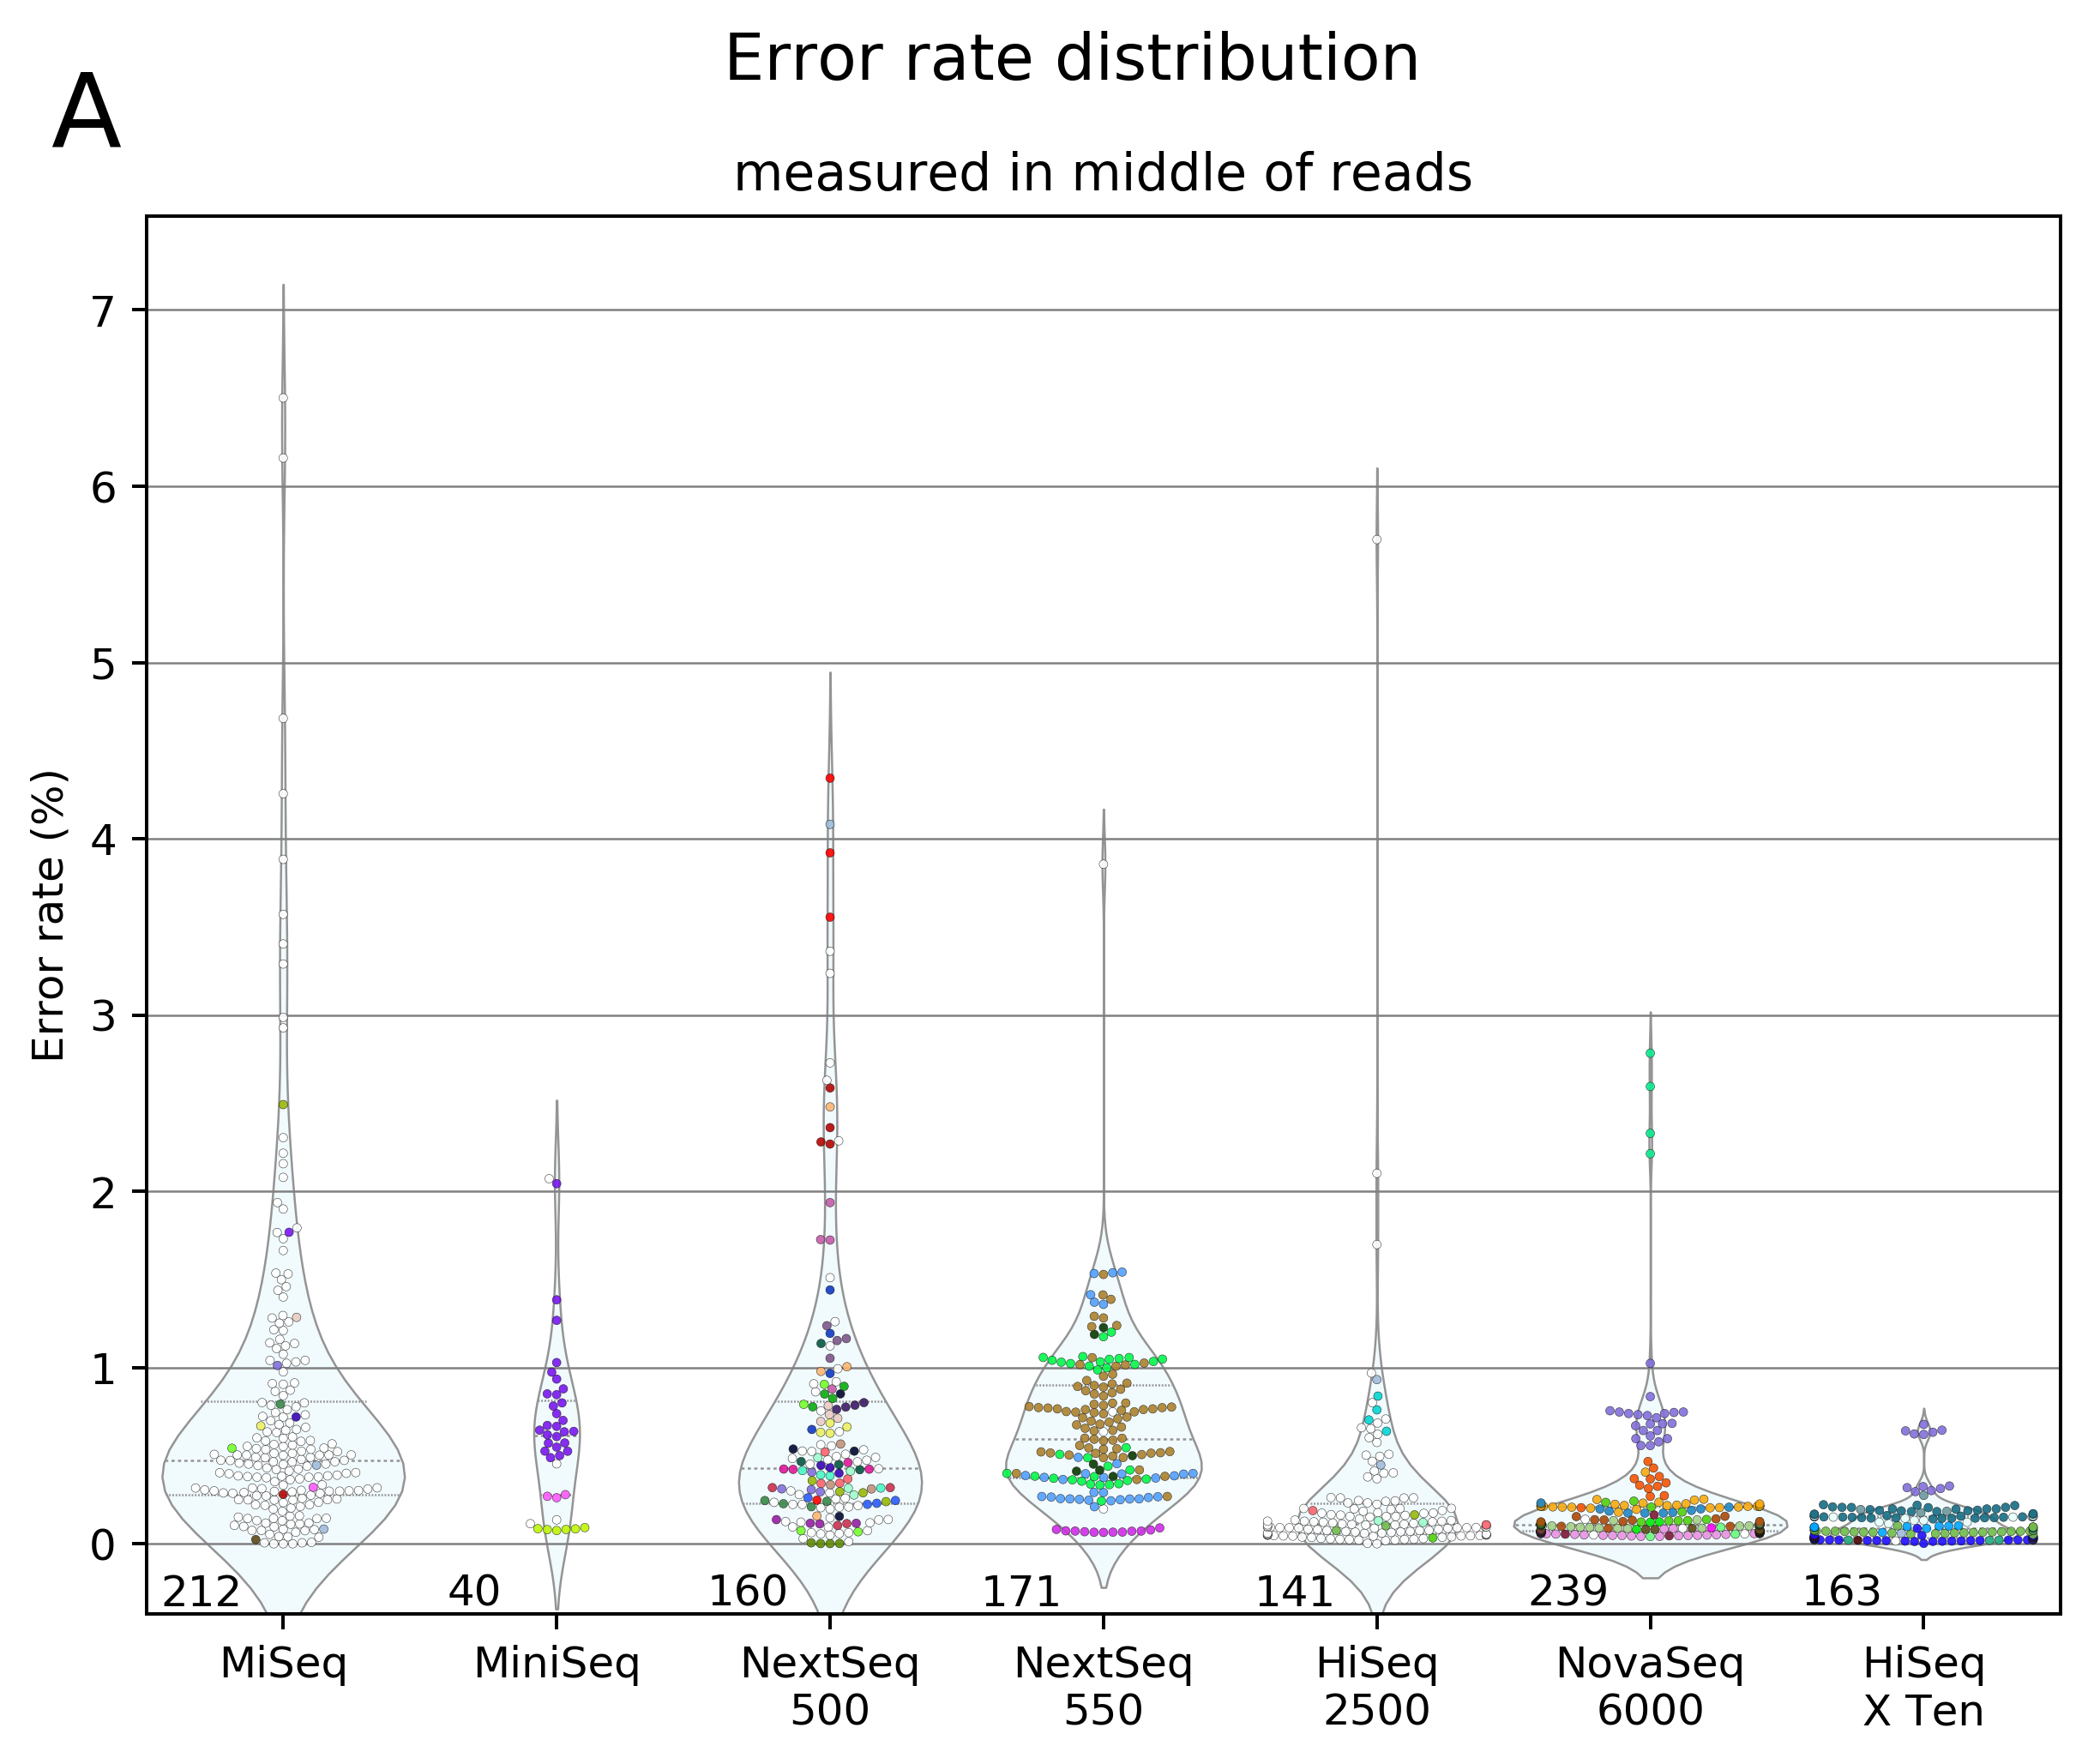

In [51]:
texts = ((-0.05, 1.05, 'A', {'fontsize':24}),)
swarmplot_rates(rates_by_platform, colors=COLORS, order=models_order, min_samples=15, size=2, texts=texts)

Took 2 seconds


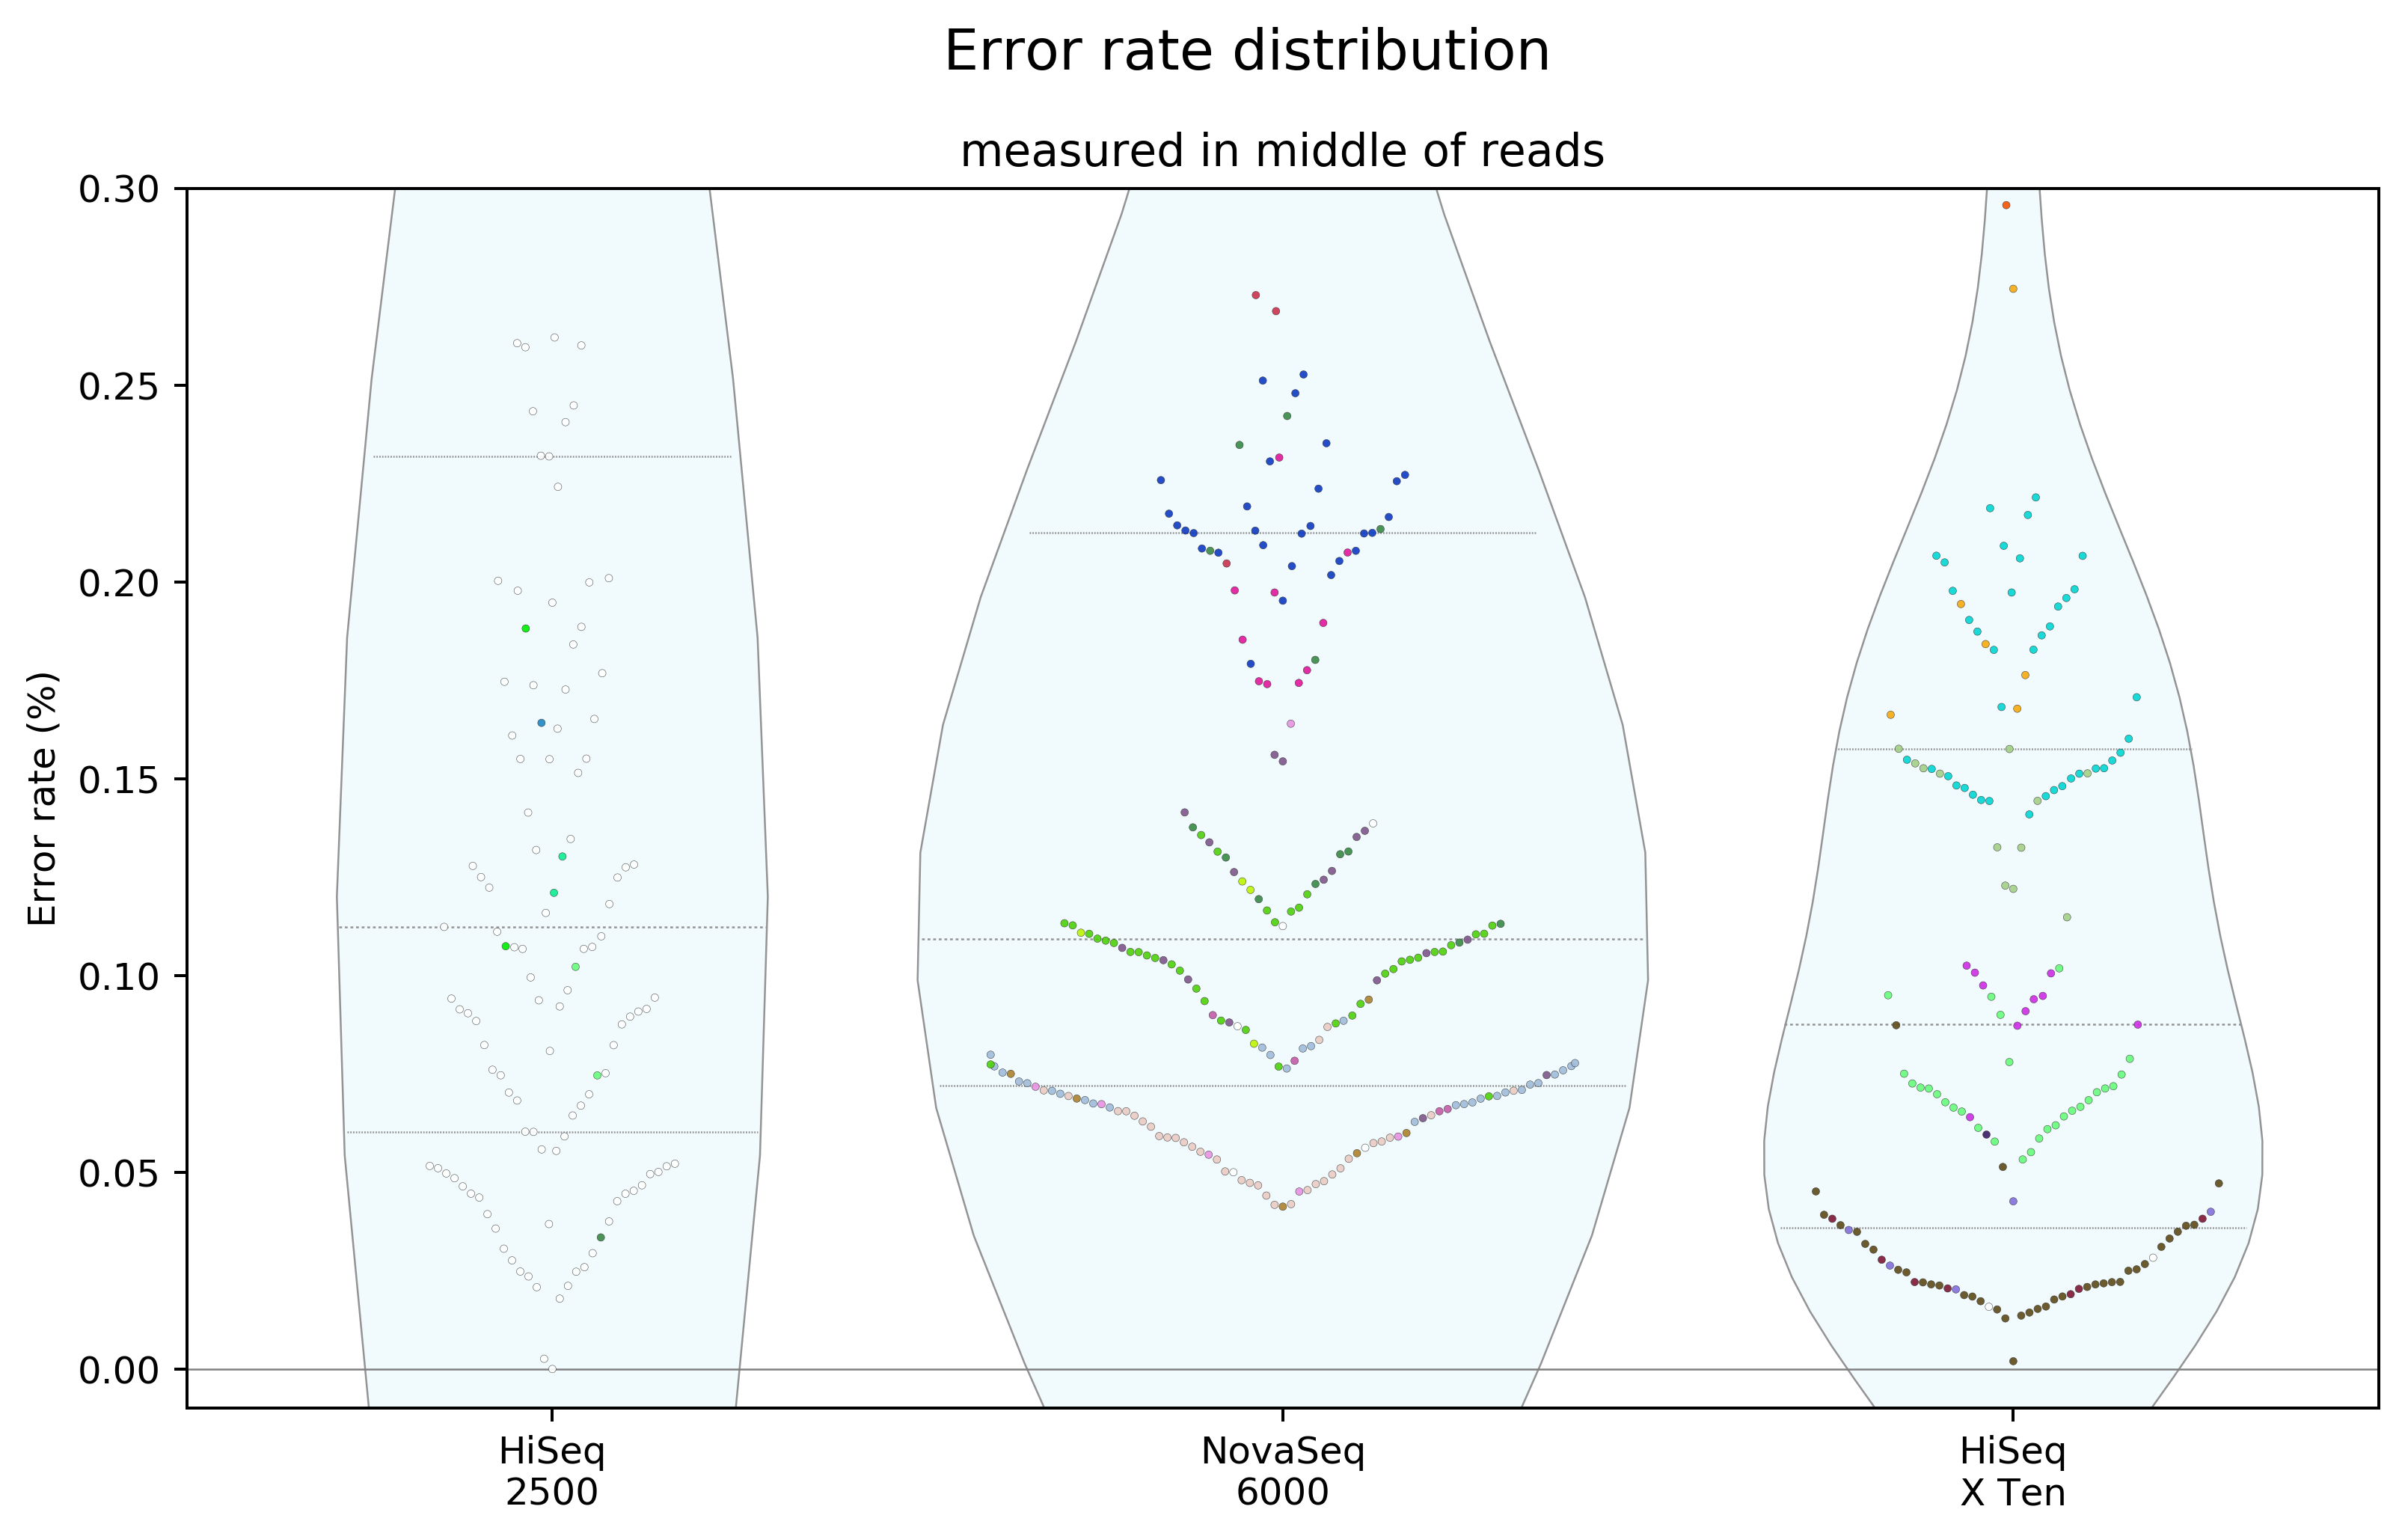

In [66]:
hinova = ('HiSeq 2500', 'NovaSeq 6000', 'HiSeq X Ten')
swarmplot_rates(
  rates_by_platform, colors=COLORS, models=hinova, min_samples=15, size=2, aspect=1.75, ymin=-0.01, ymax=0.3,
  disp_counts=False
)

Took 10 seconds


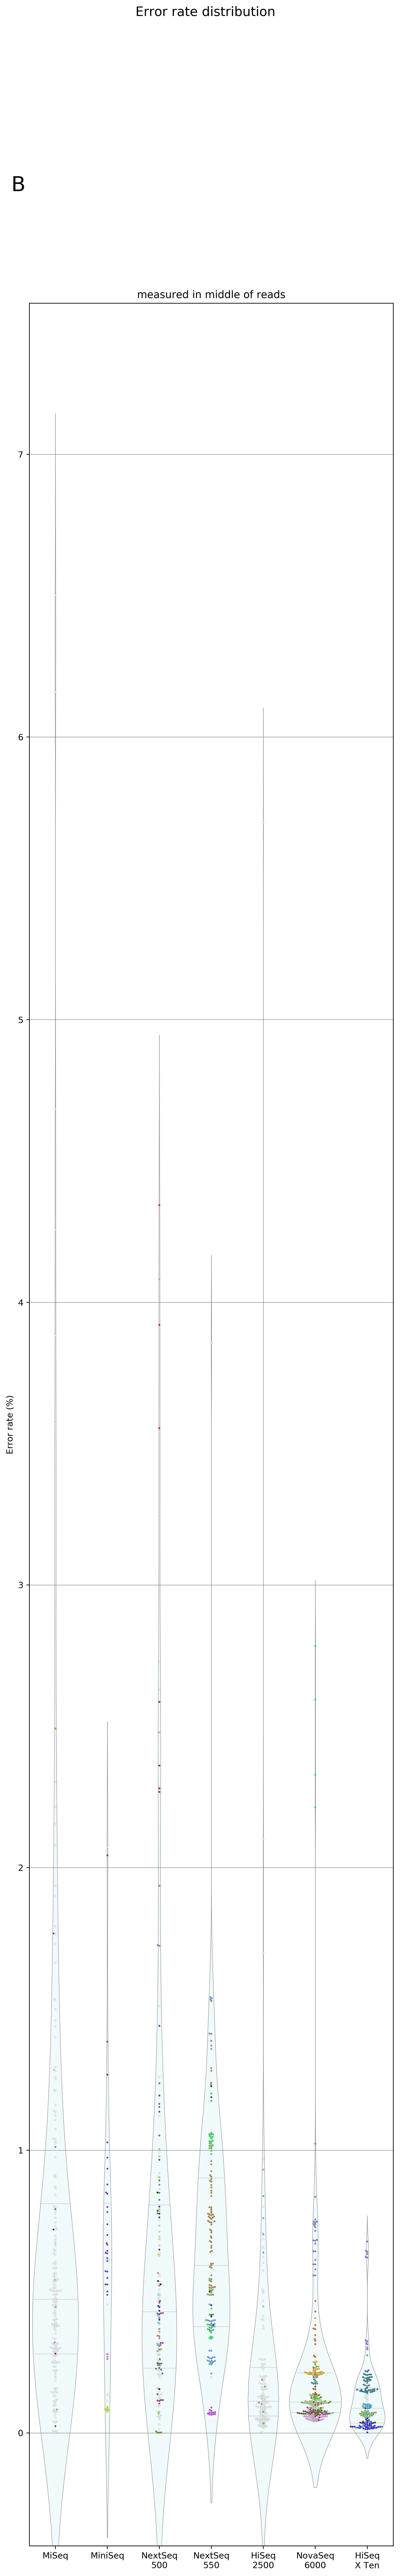

In [68]:
texts = ((-0.05, 1.05, 'B', {'fontsize':24}),)
swarmplot_rates(
  rates_by_platform, colors=COLORS, order=models_order, min_samples=15, size=2, aspect=0.158, scale=8,
  disp_counts=False, texts=texts
)

## Get summary statistics

In [31]:
def get_median(values):
  sorted_values = sorted(values)
  length = len(values)
  if length % 2 == 1:
    return sorted_values[length//2]
  else:
    left = sorted_values[length//2-1]
    right = sorted_values[length//2]
    return (left+right)/2

In [32]:
rows = []
for model in models_order:
  rates = rates_by_platform[rates_by_platform.models == model].rates
  if len(rates) < 15:
    continue
  median = get_median(rates)
  min_rate = min(rates)
  max_rate = max(rates)
  std_dev = numpy.std(rates)
  err_range = max_rate - min_rate
  rows.append((
    model, len(rates), f'{median:0.3f}', f'{std_dev:0.3f}', f'{min_rate:0.3f}', f'{max_rate:0.2f}',
    f'{err_range:0.2f}'
  ))
header = [
  [{'value':'Error rate stats', 'width':7, 'align':'center', 'size':'150%'}],
  ('Platform', 'n', 'Median', 'Std<br>Dev', 'Min', 'Max', 'Range'),
]
Table(rows, header=header).render()

In [33]:
novarates = rates_by_platform[rates_by_platform.models == 'NovaSeq 6000'].rates

In [34]:
uppergroup = [rate for rate in novarates if 0.5 < rate < 1.1]
rest = [rate for rate in novarates if rate < 0.5 or rate > 1.1]

In [35]:
get_median(uppergroup), get_median(rest)

(0.68298, 0.10537)

Took 0 seconds


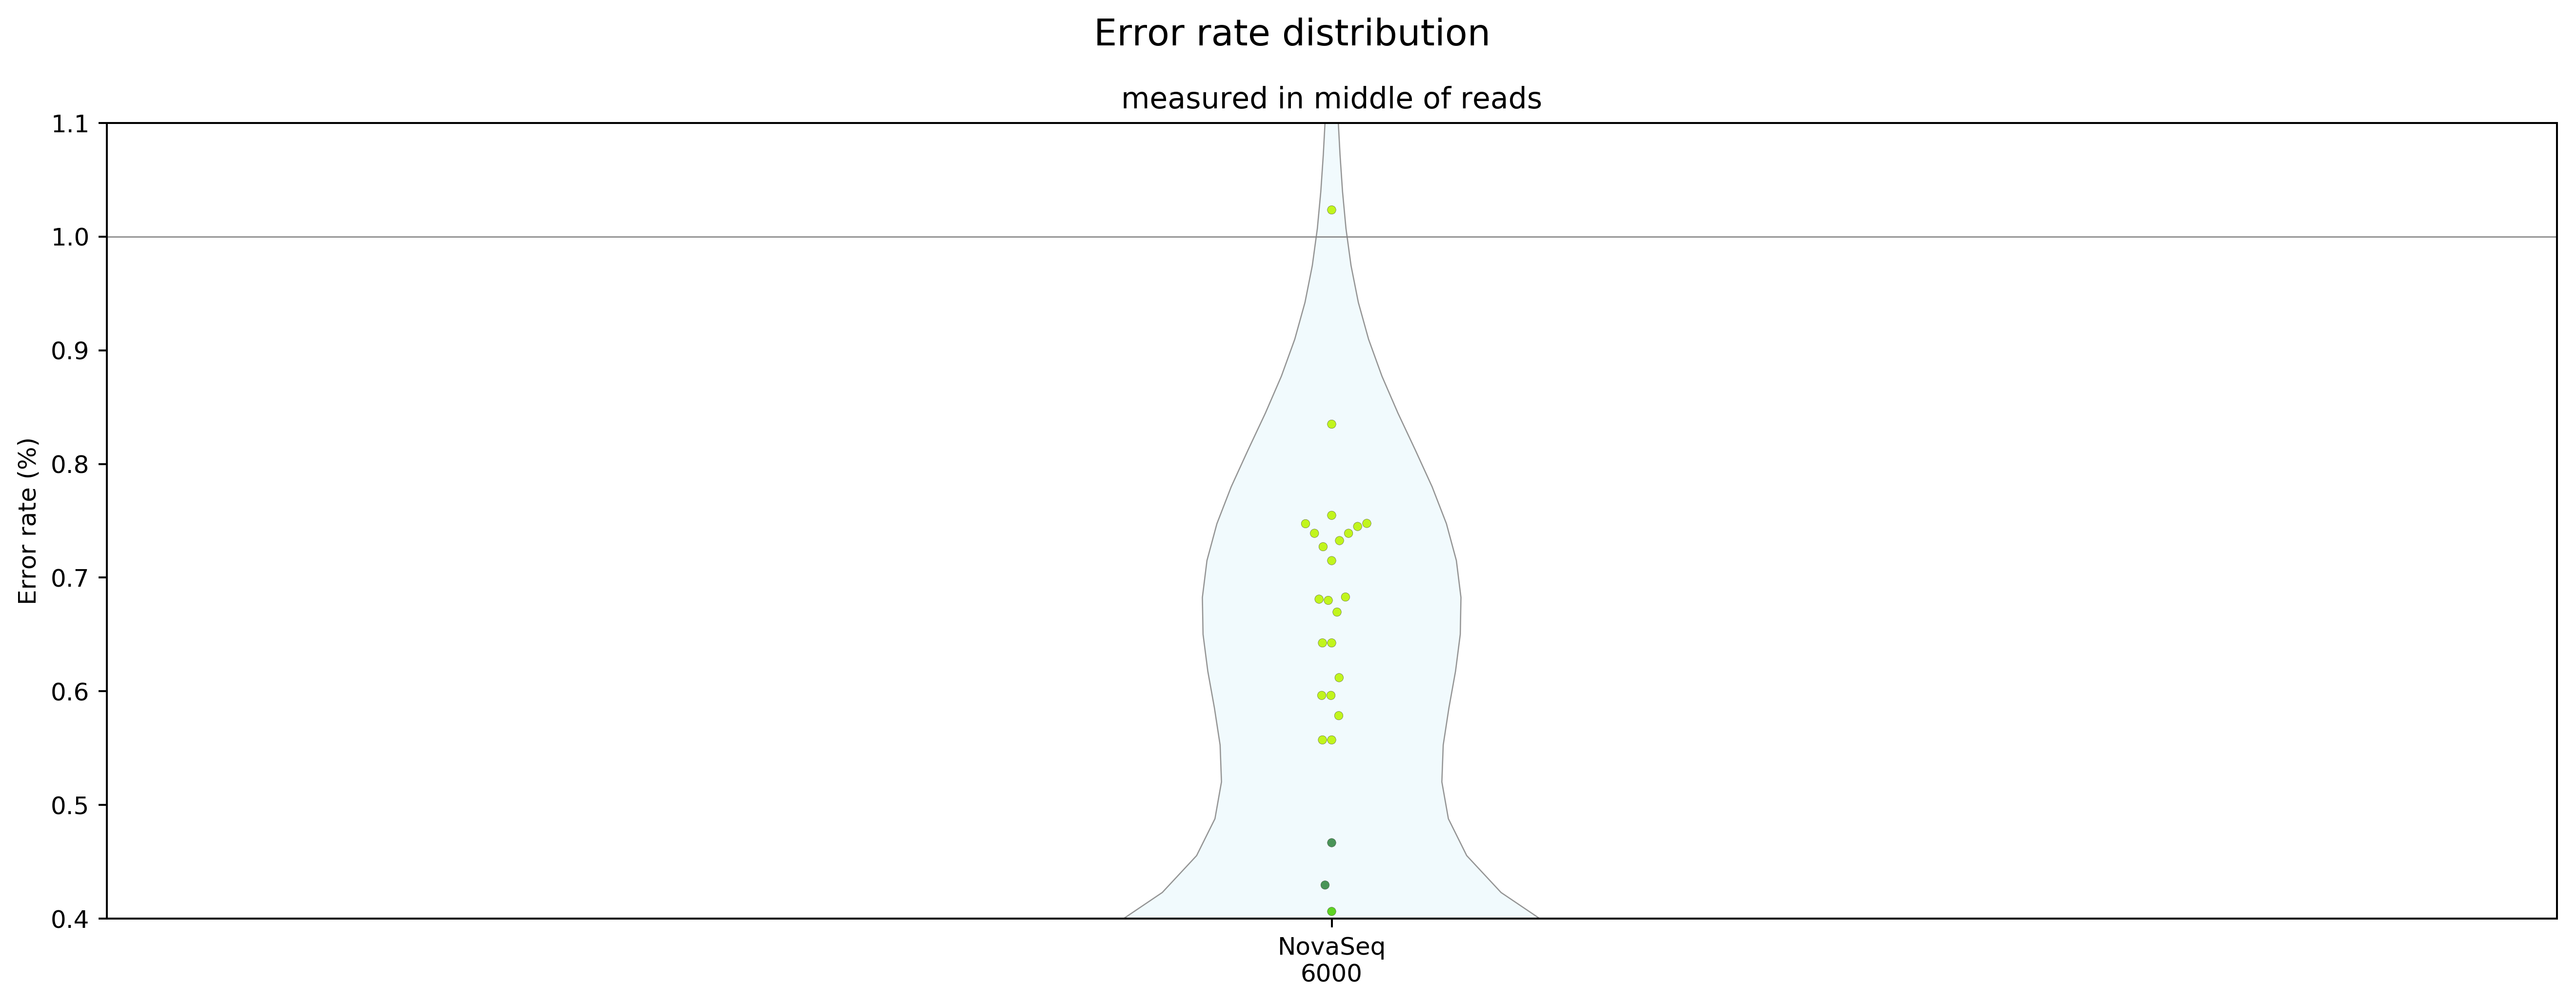

In [36]:
swarmplot_rates(
  rates_by_platform, colors=COLORS, models=('NovaSeq 6000',), min_samples=15, size=3.5, ymin=0.4, ymax=1.1,
  aspect=3, disp_counts=False
)